In [1]:
#Based on code from: https://www.kaggle.com/zhyaqi/skin-lesion-inceptionv3
#and https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [1]:
import os
import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.3.1


In [2]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
from os.path import isfile
from PIL import Image as pil_image
df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")

classes = df['dx'].unique()
labeldict = {}
for num, name in enumerate(classes):
    labeldict[name] = num
df['dx_id'] = df['dx'].map(lambda x: labeldict[x])


def expand_path(p):
    if isfile('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/' + p + '.jpg'): return '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/' + p + '.jpg'
    if isfile('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2/' + p + '.jpg'): return '../input/skin-cancer-mnist-ham10000/ham10000_images_part_2/' + p + '.jpg'
    return p 
df['image_path'] = df['image_id']
df['image_path'] = df['image_path'].apply(expand_path)


df['images'] = df['image_path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,112))))
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,num_images,dx_id,image_path,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[188, 151, 193], [193, 156, 198], [192, 155,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[24, 13, 22], [24, 13, 22], [24, 14, 25], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[186, 126, 135], [189, 131, 142], [192, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[23, 11, 16], [24, 11, 19], [26, 13, 22], [3..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[129, 87, 109], [139, 94, 117], [148, 102, 1..."


In [9]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

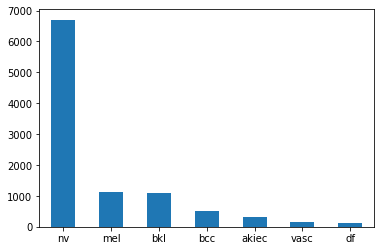

In [130]:
df['dx'].value_counts().plot.bar(rot=0)

In [14]:
from sklearn.model_selection import train_test_split

df_single = df[df['num_images'] == 1]
trainset1, testset = train_test_split(df_single, test_size=0.2,random_state = 700)
trainset2, validationset = train_test_split(trainset1, test_size=0.2,random_state = 234)
trainset3 = df[df['num_images'] != 1]
frames = [trainset2, trainset3]
trainset = pd.concat(frames)

def prepareimages(images):
    # images is a list of images
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images
trainimages = prepareimages(list(trainset['images']))
testimages = prepareimages(list(testset['images']))
validationimages = prepareimages(list(validationset['images']))
trainlabels = np.asarray(trainset['dx_id'])
testlabels = np.asarray(testset['dx_id'])
validationlabels = np.asarray(validationset['dx_id'])
print(np.shape(trainimages))
print(np.shape(testimages))
print(np.shape(validationimages))

(8029, 112, 150, 3)
(1103, 112, 150, 3)
(883, 112, 150, 3)


In [15]:
from keras.preprocessing.image import ImageDataGenerator

trainimages = trainimages.reshape(trainimages.shape[0], *(112, 150, 3))

data_gen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True, 
        vertical_flip=True)
#x = imageLoader(trainset,batch_size)
data_gen.fit(trainimages)

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

input_shape = (112, 150, 3)

num_labels = 7

base_model = inc_net.InceptionV3(include_top=False, input_shape=(112, 150, 3),pooling = 'avg', weights = '../input/inception/inception_v3_weights.h5')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 22,065,959
Trainable params: 22,031,527
Non-trainable params: 34,432
_________________________________________________________________


In [17]:
from keras.optimizers import Adam
optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [9]:
# Fit the model
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
class CustomModelCheckPoint(keras.callbacks.Callback):
    def __init__(self,**kargs):
        super(CustomModelCheckPoint,self).__init__(**kargs)
        self.epoch_accuracy = {} # loss at given epoch
        self.epoch_loss = {} # accuracy at given epoch
        def on_epoch_begin(self,epoch, logs={}):
            # Things done on beginning of epoch. 
            return

        def on_epoch_end(self, epoch, logs={}):
            # things done on end of the epoch
            self.epoch_accuracy[epoch] = logs.get("acc")
            self.epoch_loss[epoch] = logs.get("loss")
            self.model.save_weights("name-of-model-%d.h5" %epoch)
            
checkpoint = CustomModelCheckPoint()
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best2.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
epochs = 20 
batch_size = 20
trainhistory = model.fit_generator(data_gen.flow(trainimages,trainlabels, batch_size=batch_size),
                              epochs = epochs, validation_data = (validationimages,validationlabels),
                              verbose = 1, steps_per_epoch=trainimages.shape[0] // batch_size,
                                       callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/20
401/401 [==============================] - 87s 216ms/step - loss: 3.2172 - accuracy: 0.6488 - val_loss: 1.6272 - val_accuracy: 0.6229
Epoch 2/20
401/401 [==============================] - 57s 143ms/step - loss: 1.2586 - accuracy: 0.6910 - val_loss: 0.6779 - val_accuracy: 0.8505
Epoch 3/20
401/401 [==============================] - 104s 259ms/step - loss: 0.9877 - accuracy: 0.7043 - val_loss: 0.5946 - val_accuracy: 0.8437
Epoch 4/20
401/401 [==============================] - 162s 405ms/step - loss: 0.9167 - accuracy: 0.7153 - val_loss: 0.7383 - val_accuracy: 0.7916
Epoch 5/20
401/401 [==============================] - 169s 422ms/step - loss: 0.8496 - accuracy: 0.7345 - val_loss: 1.0817 - val_accuracy: 0.6988
Epoch 6/20
401/401 [==============================] - 173s 432ms/step - loss: 0.8263 - accuracy: 0.7392 - val_loss: 0.5635 - val_accuracy: 0.8448
Epoch 7/20
401/401 [==============================] - 171s 427ms/step - loss: 0.8372 - accuracy: 0.7463 - val_loss: 0.5751 - v

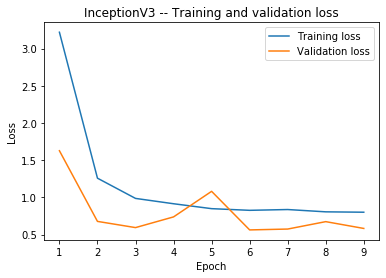

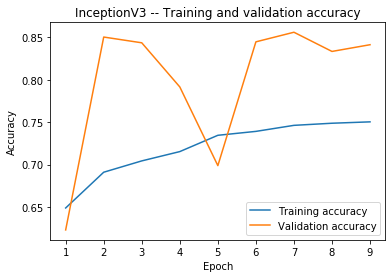

In [10]:
import matplotlib.pyplot as plt
acc = trainhistory.history['accuracy']
val_acc = trainhistory.history['val_accuracy']
loss = trainhistory.history['loss']
val_loss = trainhistory.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '', label='Training loss')
plt.plot(epochs, val_loss, '', label='Validation loss')
plt.title('InceptionV3 -- Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, '', label='Training accuracy')
plt.plot(epochs, val_acc, '', label='Validation accuracy')
plt.title('InceptionV3 -- Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [18]:
model.load_weights("../working/best2.hdf5")
test_loss, test_acc = model.evaluate(testimages, testlabels, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))

1103/1103 [==============================] - 10s 9ms/step
test_accuracy = 0.865820  ;  test_loss = 0.542562


[0.03374891 0.9262487  0.00361323 0.02490733 0.00236971 0.0069206
 0.0021915 ]


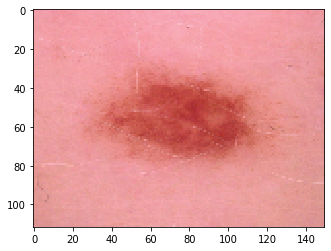

In [73]:
test_image = image.load_img('..\input\skin-cancer-mnist-ham10000\ham10000_images_part_1\ISIC_0026800.jpg', target_size = (112,150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
test_image = inc_net.preprocess_input(test_image)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(test_image[0] / 2 + 0.5)
preds = model.predict(test_image)
for x in preds:
    print(x)

In [14]:
df[['dx', 'dx_id']].drop_duplicates()

,dx,dx_id
0,bkl,0
64,nv,1
1095,df,2
1211,mel,3
2320,vasc,4
2462,bcc,5
9687,akiec,6


In [24]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [25]:
explainer = lime_image.LimeImageExplainer()

In [74]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
global explanation
explanation = explainer.explain_instance(test_image[0], model.predict, top_labels=7, hide_color=0, num_samples=1000)
explanation.top_labels


Wall time: 3.08 s


[1, 0, 3, 5, 2, 4, 6]

In [27]:
from skimage.segmentation import mark_boundaries

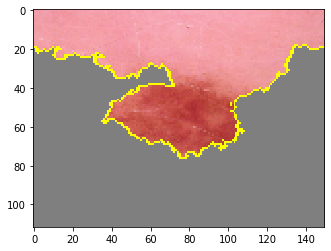

In [75]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

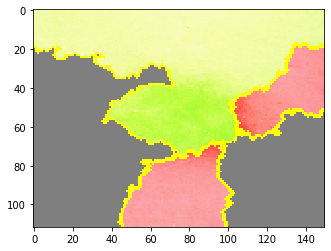

In [118]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=8, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

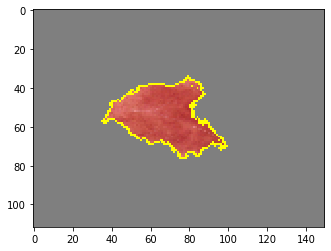

In [128]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1000, hide_rest=True, min_weight=0.0008)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [22]:
from sklearn.metrics import confusion_matrix
train_pred = model.predict(trainimages)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = model.predict(testimages)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

confusionmatrix = confusion_matrix(testlabels, test_pred_classes)
confusionmatrix

array([[ 51,  21,   0,   9,   1,   4,   1],
       [ 30, 841,   0,   7,   5,   2,   1],
       [  2,   2,   0,   0,   0,   3,   1],
       [ 13,   6,   0,  14,   0,   2,   1],
       [  0,   0,   0,   0,  14,   0,   0],
       [  3,   3,   0,   3,   0,  29,   2],
       [  7,   6,   0,   3,   0,  10,   6]], dtype=int64)

In [23]:
from sklearn.metrics import classification_report
labels = labeldict.keys()
# Generate a classification report
#trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
testreport = classification_report(testlabels, test_pred_classes, target_names=list(labels))
#print(trainreport)
print(testreport)

              precision    recall  f1-score   support

         bkl       0.48      0.59      0.53        87
          nv       0.96      0.95      0.95       886
          df       0.00      0.00      0.00         8
         mel       0.39      0.39      0.39        36
        vasc       0.70      1.00      0.82        14
         bcc       0.58      0.72      0.64        40
       akiec       0.50      0.19      0.27        32

    accuracy                           0.87      1103
   macro avg       0.52      0.55      0.52      1103
weighted avg       0.86      0.87      0.86      1103



C:\Users\home\.conda\envs\XAI\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
